In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Download Stock Data

In [2]:
import threading

date = '2019-05-31'
ticker_request_case_study = ['TDOC','WD','KNSL','BOMN','APPN']
ticker_request_yahoo_top30 = ['AAPL','MSFT','GOOG','AMZN','FB','TSLA','NVDA','DIS','NVO','AMD','ABNB','GM','NIO','F','RBLX','CRWD','DOCU','BIIB','NOK','AMC','GME','UPST','PSFE','TLRY','BB','PSTH','CLOV','BBBY','MVIS','SAML']
ticker_request_motley_fool_top30 = ['BTC','CMPS','CSTL','CURI','DCBO','GSHD','OM','UPST','CALT','DAVA','FLGT','FTHM','LMND','PUBM','SPT','TTCF','AVIR','BIGC','CELH','DOCN','FVRR','INMD','RETA','SMLR','YALA','AMWL','BTRS','DMTK','FROG','KOD','PGNY','POSH','SKLZ','RWM','VINP']
tickers = []
stocks = {}

def downloadStocks(ticker, date):
    try:
        stocks[ticker] = pdr.get_data_yahoo(ticker,date)
        stocks[ticker].drop('Adj Close', axis=1, inplace=True)
        stocks[ticker].drop('High', axis=1, inplace=True)
        stocks[ticker].drop('Low', axis=1, inplace=True)
        stocks[ticker].drop('Open', axis=1, inplace=True)
        stocks[ticker].drop('Volume', axis=1, inplace=True)
        tickers.append(ticker)
    except:
        print("Failed to get %s" % ticker)

threads = []

for ticker in ticker_request_case_study:
    ticker_thread = threading.Thread(target=downloadStocks, args=(ticker, date,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

print(tickers)
stocks[tickers[0]].head()

['APPN', 'TDOC', 'WD', 'BOMN', 'KNSL']


,Close
Date,
2019-05-31,36.130001
2019-06-03,33.299999
2019-06-04,34.360001
2019-06-05,34.730000
2019-06-06,34.220001


## Generate Baseline Performance and Moving Average (MA) Performance

In [3]:
def generateSystems(ticker):
    stocks[ticker]['3-day'] = stocks[ticker]['Close'].rolling(3).mean()
    stocks[ticker]['9-day'] = stocks[ticker]['Close'].rolling(9).mean()
    stocks[ticker]['21-day'] = stocks[ticker]['Close'].rolling(21).mean()
    stocks[ticker]['Change'] = (stocks[ticker].Close-stocks[ticker].Close.shift())/stocks[ticker].Close.shift()
    
    # When the faster moving average is moving above the slower one, indicates time to buy
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] > stocks[ticker]['9-day'], 1,0)
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] > stocks[ticker]['21-day'], 1,0)
    # When the faster moving average is moving below the slower one, indicates time to sell
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] <= stocks[ticker]['9-day'],-1,stocks[ticker]['position-3-9'])
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] <= stocks[ticker]['21-day'],-1,stocks[ticker]['position-9-21'])
    
    # Whether we are making money with this system
    stocks[ticker]['system-3-9'] = np.where(stocks[ticker]['position-3-9'] > 0, stocks[ticker]['position-3-9']* stocks[ticker]['Change'],0)
    stocks[ticker]['system-9-21'] = np.where(stocks[ticker]['position-9-21'] > 0, stocks[ticker]['position-9-21']* stocks[ticker]['Change'],0)

    stocks[ticker]['Volatility'] = stocks[ticker].Change.rolling(21).std().shift()
    
threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

,Close,3-day,9-day,21-day,Change,position-3-9,position-9-21,system-3-9,system-9-21,Volatility
Date,,,,,,,,,,
2021-06-02,93.970001,90.676669,86.631111,87.721428,0.072962,1,-1,0.072962,0.000000,0.044173
2021-06-03,91.410004,90.986669,87.454445,87.013333,-0.027243,1,1,-0.027243,-0.027243,0.047387
2021-06-04,90.959999,92.113335,88.414445,86.472857,-0.004923,1,1,-0.004923,-0.004923,0.044763
2021-06-07,94.699997,92.356667,89.593334,86.271428,0.041117,1,1,0.041117,0.041117,0.044189
2021-06-08,111.820000,99.159999,92.788890,87.392857,0.180781,1,1,0.180781,0.180781,0.044766


## Generate DGIM MA Performance

In [4]:
%reload_ext autoreload
%autoreload 2
from ipynb.fs.full.DGIMMovingAverage import *
import threading

bit_depth = 16
num_buckets = 5

def generateDGIMSystems(ticker):
    stocks_list = stocks[ticker]['Close'].tolist()
    stocks_3day_list = stocks[ticker]['3-day'].tolist()
    stocks_9day_list = stocks[ticker]['9-day'].tolist()
    stocks_21day_list = stocks[ticker]['21-day'].tolist()
    stocks_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in stocks_list ]

    try:
        dgim_3day = DGIMMovingAverage(stocks_list_bin, 3, num_buckets, bit_depth, stocks_3day_list, True)
        stocks[ticker]['3-day-dgim'] = dgim_3day.mov_avg
        dgim_9day = DGIMMovingAverage(stocks_list_bin, 9, num_buckets, bit_depth, stocks_9day_list, True)
        stocks[ticker]['9-day-dgim'] = dgim_9day.mov_avg
        dgim_21day = DGIMMovingAverage(stocks_list_bin, 21, num_buckets, bit_depth, stocks_21day_list, True)
        stocks[ticker]['21-day-dgim'] = dgim_21day.mov_avg

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] > stocks[ticker]['9-day-dgim'], 1,0)
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] > stocks[ticker]['21-day-dgim'], 1,0)

        # When the faster moving average is moving below the slower one, indicates time to sell\
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] <= stocks[ticker]['9-day-dgim'],-1,stocks[ticker]['position-dgim-3-9'])
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] <= stocks[ticker]['21-day-dgim'],-1,stocks[ticker]['position-dgim-9-21'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9'] = np.where(stocks[ticker]['position-dgim-3-9'] > 0, stocks[ticker]['position-dgim-3-9']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21'] = np.where(stocks[ticker]['position-dgim-9-21'] > 0, stocks[ticker]['position-dgim-9-21']* stocks[ticker]['Change'],0)
        
    except Exception as e:
        print("Failed to analyze %s" % ticker, e)
        tickers.remove(ticker)

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateDGIMSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## Generate Normalized DGIM MA Performance

In [5]:
def normalizeDGIM(ticker):
    try:
        stocks[ticker]['3-day-dgim-norm']=(stocks[ticker]['3-day-dgim']-stocks[ticker]['3-day-dgim'].mean())/stocks[ticker]['3-day-dgim'].std()
        stocks[ticker]['9-day-dgim-norm']=(stocks[ticker]['9-day-dgim']-stocks[ticker]['9-day-dgim'].mean())/stocks[ticker]['9-day-dgim'].std()
        stocks[ticker]['21-day-dgim-norm']=(stocks[ticker]['21-day-dgim']-stocks[ticker]['21-day-dgim'].mean())/stocks[ticker]['21-day-dgim'].std()

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] > stocks[ticker]['9-day-dgim-norm'], 1,0)
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] > stocks[ticker]['21-day-dgim-norm'], 1,0)
        # When the faster moving average is moving below the slower one, indicates time to sell
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] <= stocks[ticker]['9-day-dgim-norm'],-1,stocks[ticker]['position-dgim-3-9-norm'])
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] <= stocks[ticker]['21-day-dgim-norm'],-1,stocks[ticker]['position-dgim-9-21-norm'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9-norm'] = np.where(stocks[ticker]['position-dgim-3-9-norm'] > 0, stocks[ticker]['position-dgim-3-9-norm']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21-norm'] = np.where(stocks[ticker]['position-dgim-9-21-norm'] > 0, stocks[ticker]['position-dgim-9-21-norm']* stocks[ticker]['Change'],0)
    except:
        pass

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=normalizeDGIM, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

,Close,3-day,9-day,21-day,Change,position-3-9,position-9-21,system-3-9,system-9-21,Volatility,...,position-dgim-9-21,system-dgim-3-9,system-dgim-9-21,3-day-dgim-norm,9-day-dgim-norm,21-day-dgim-norm,position-dgim-3-9-norm,position-dgim-9-21-norm,system-dgim-3-9-norm,system-dgim-9-21-norm
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-02,93.970001,90.676669,86.631111,87.721428,0.072962,1,-1,0.072962,0.000000,0.044173,...,-1,0.000000,0.000000,0.186020,0.198288,0.196911,-1,1,0.000000,0.072962
2021-06-03,91.410004,90.986669,87.454445,87.013333,-0.027243,1,1,-0.027243,-0.027243,0.047387,...,-1,0.000000,0.000000,0.195244,0.218680,0.217716,-1,1,0.000000,-0.027243
2021-06-04,90.959999,92.113335,88.414445,86.472857,-0.004923,1,1,-0.004923,-0.004923,0.044763,...,-1,0.000000,0.000000,0.204467,0.241985,0.209149,-1,1,0.000000,-0.004923
2021-06-07,94.699997,92.356667,89.593334,86.271428,0.041117,1,1,0.041117,0.041117,0.044189,...,-1,0.000000,0.000000,0.204467,0.244898,0.199359,-1,1,0.000000,0.041117
2021-06-08,111.820000,99.159999,92.788890,87.392857,0.180781,1,1,0.180781,0.180781,0.044766,...,1,0.180781,0.180781,0.499625,0.335204,0.228730,1,1,0.180781,0.180781


## View Individual Stocks DGIM/Normalized DGIM MA vs. Baseline and MA Performance

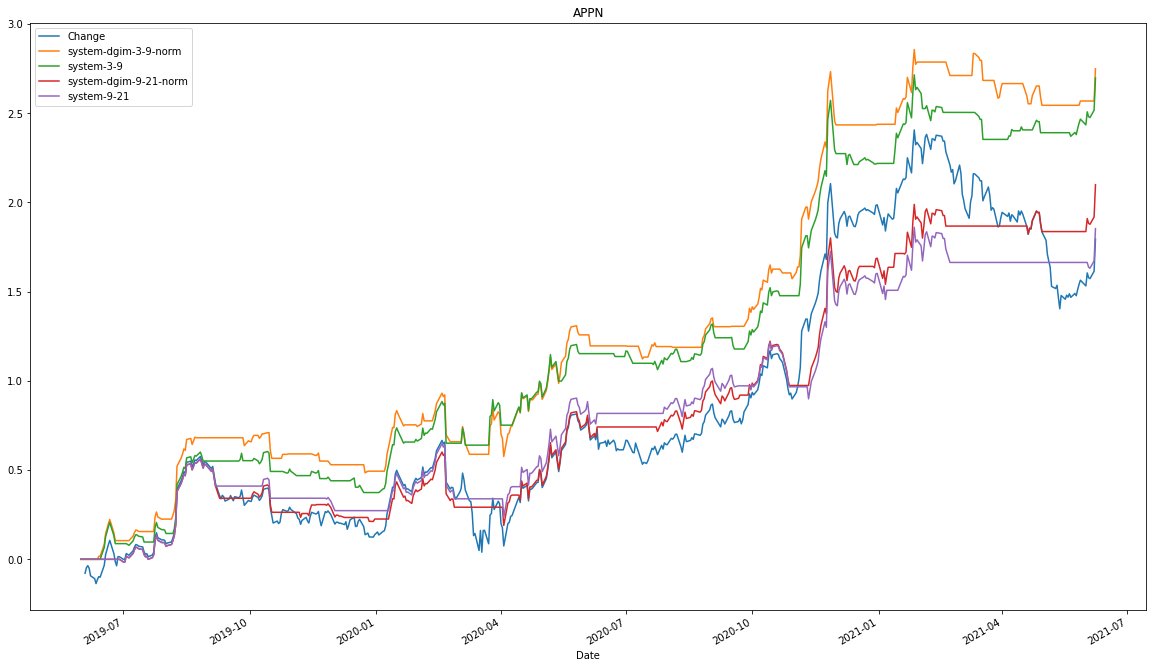

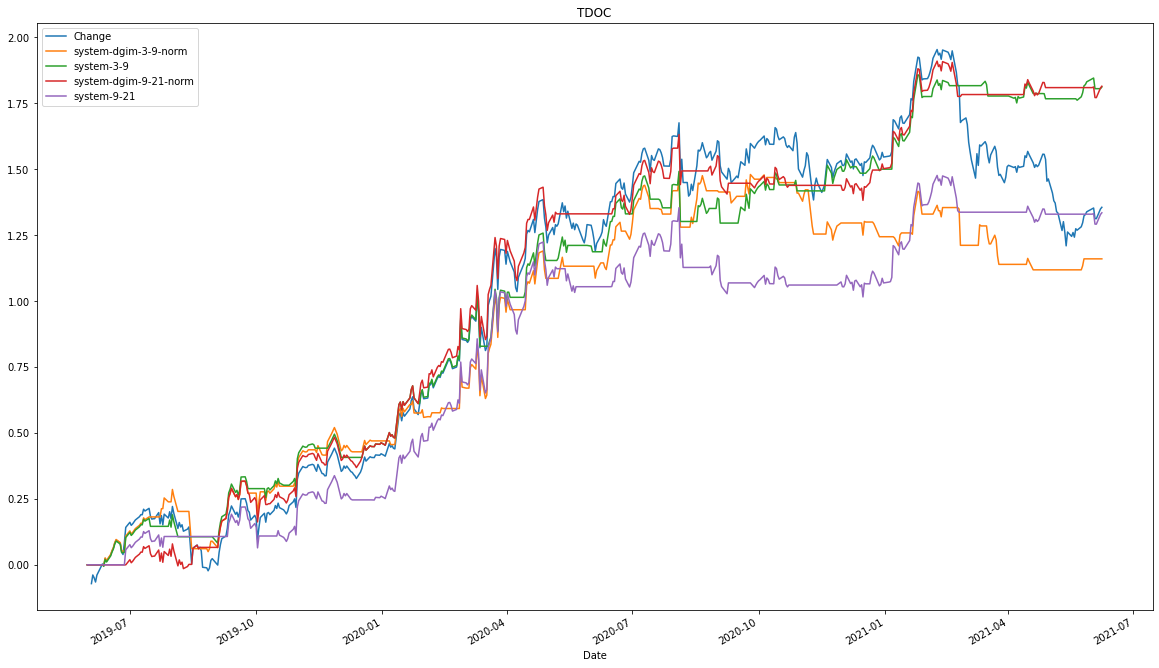

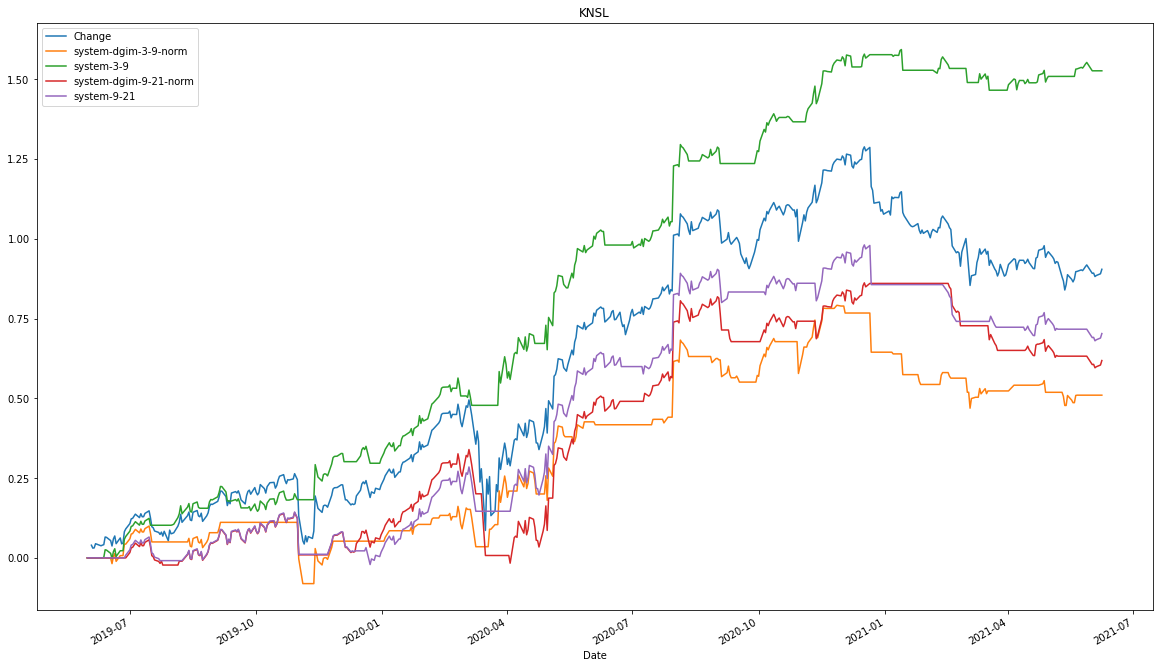

In [6]:
def printSystems(ticker):
    stocks[ticker][['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().plot(title=ticker,figsize=(20,12))

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=printSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Performance

,Change,system-dgim-3-9-norm,system-3-9,system-dgim-9-21-norm,system-9-21
2021-06-04,5.297723,6.182526,8.888204,5.977586,5.103996
2021-06-05,5.297723,6.182526,8.888204,5.977586,5.103996
2021-06-06,5.297723,6.182526,8.888204,5.977586,5.103996
2021-06-07,5.439079,6.234969,8.987512,6.113194,5.245351
2021-06-08,5.648764,6.406775,9.183108,6.305537,5.455036


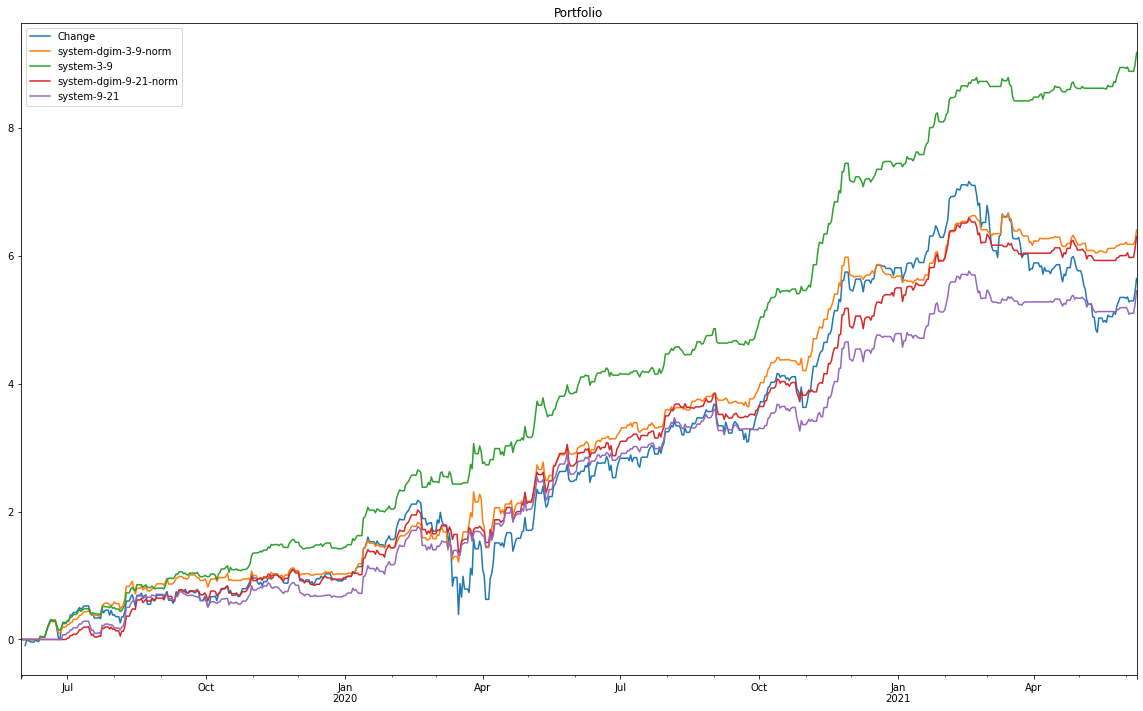

In [7]:
portfolio = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio += stocks[ticker].reindex(idx, fill_value=0)

portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().replace(to_replace=0, method='ffill').plot(title="Portfolio",figsize=(20,12))
portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().tail()

## Generate USD Gain

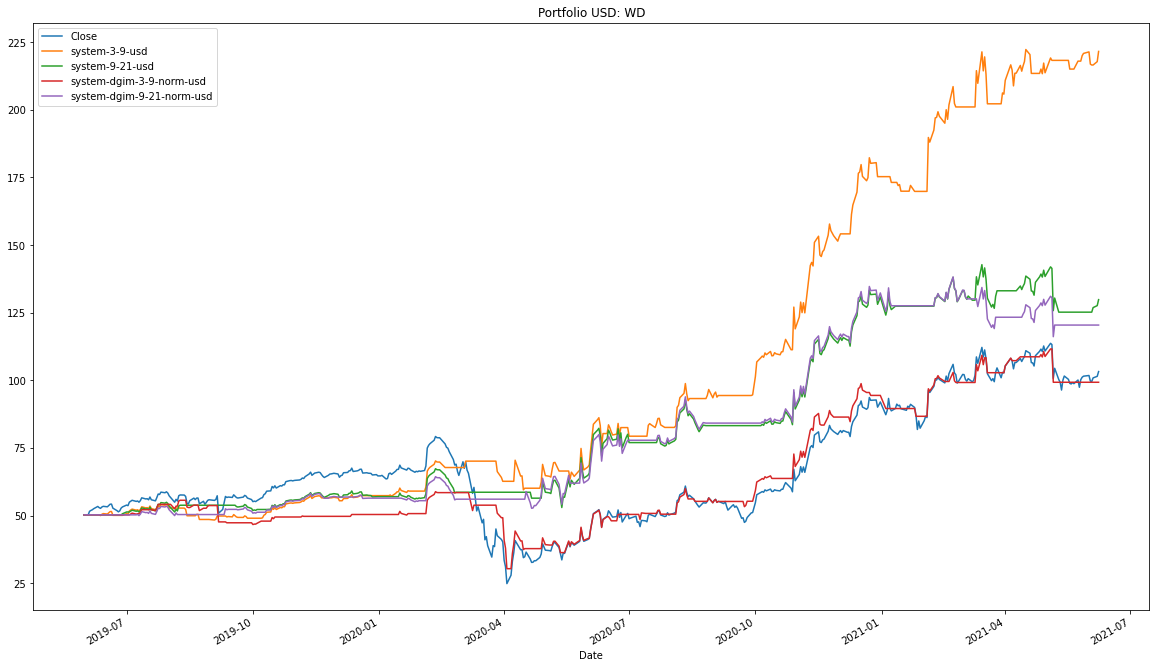

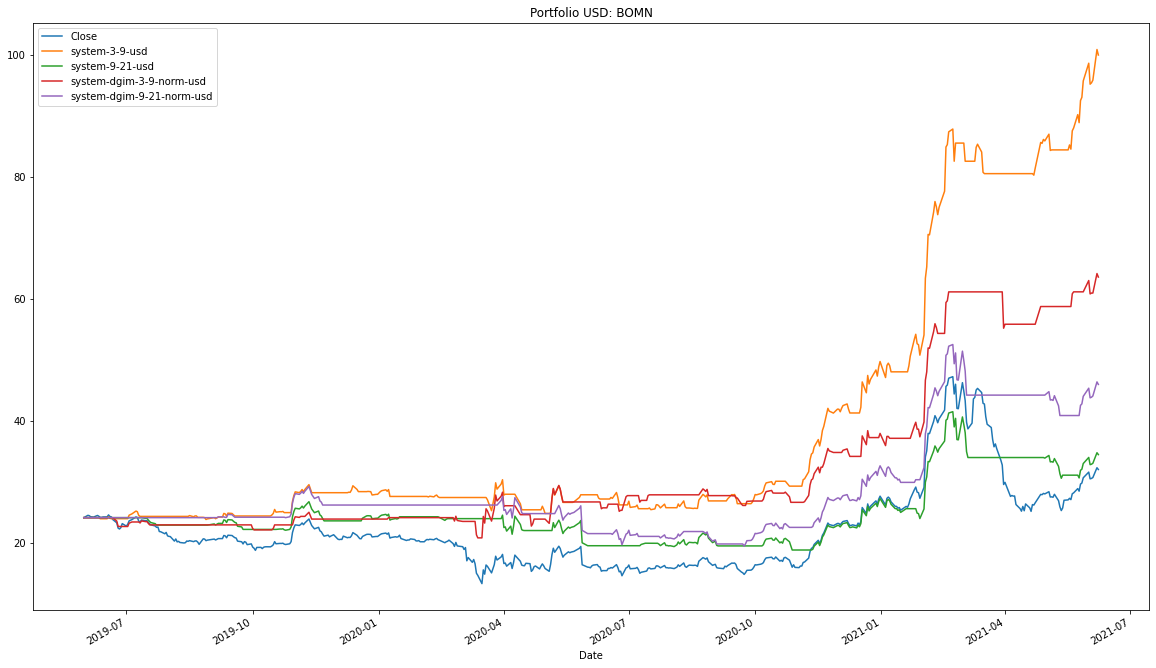

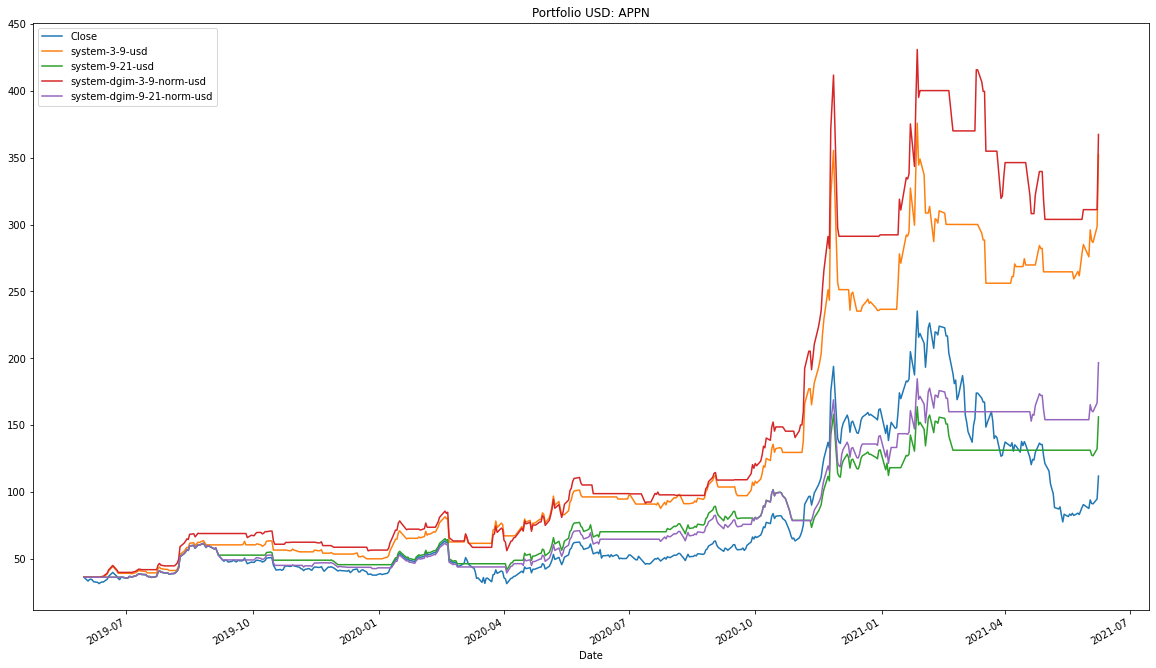

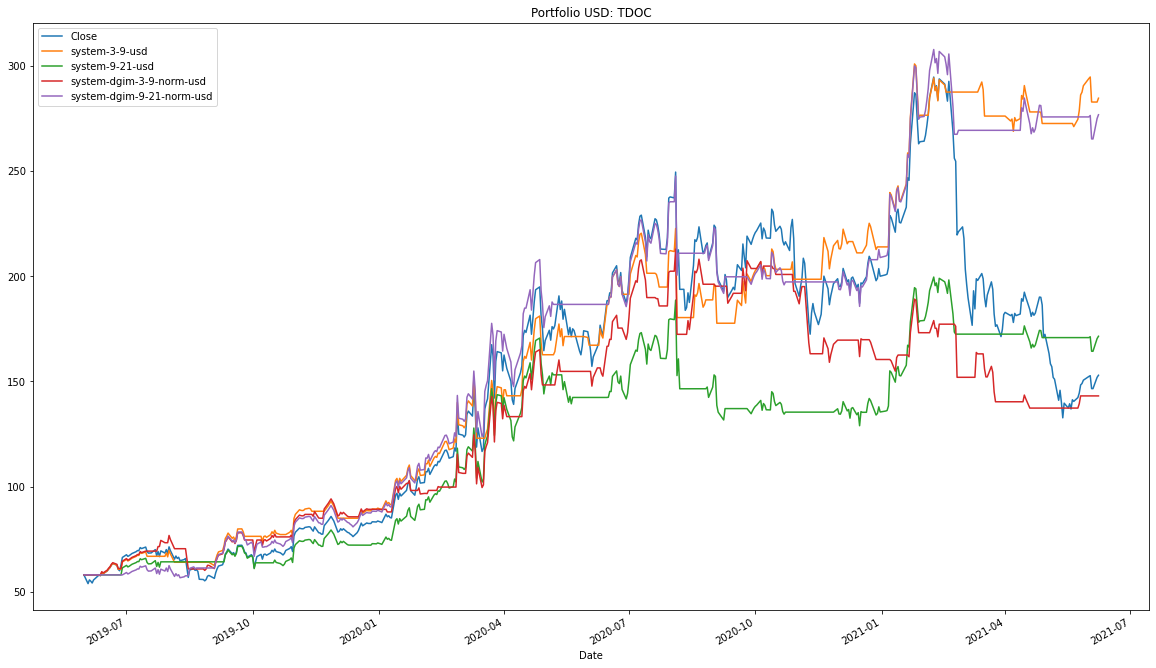

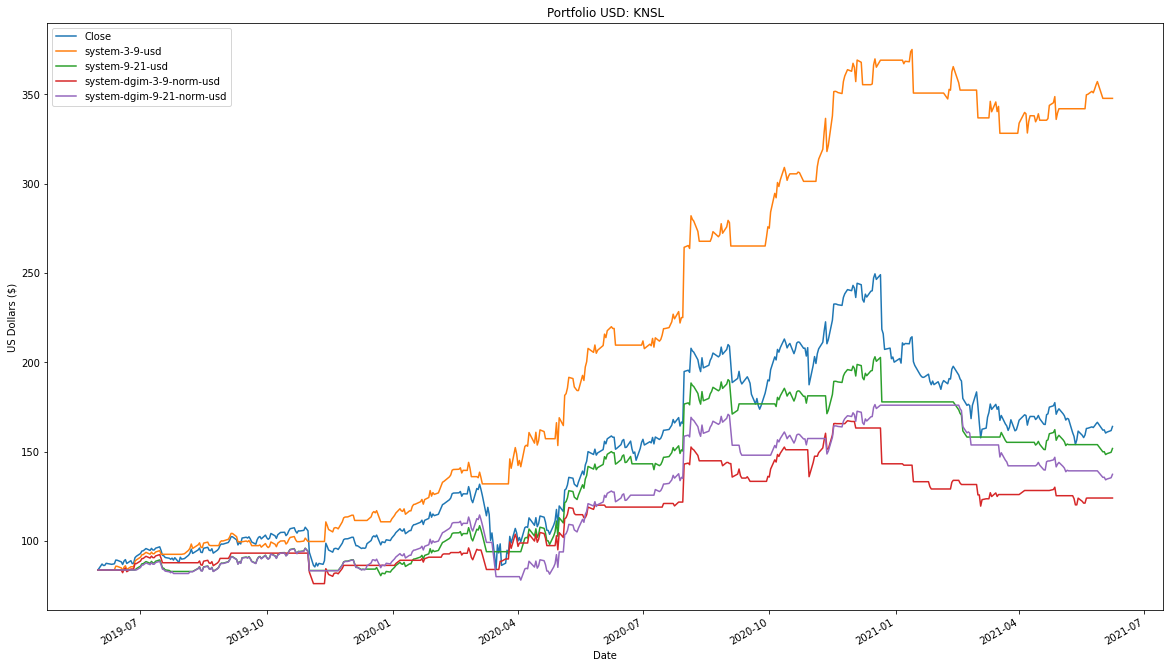

In [8]:
def GenerateUSD(ticker):
    sys39 = [stocks[ticker]['Close'][0]]
    sys921 = [stocks[ticker]['Close'][0]]
    sysdgimnorm39 = [stocks[ticker]['Close'][0]]
    sysdgimnorm921 = [stocks[ticker]['Close'][0]]
    
    for i in range(1,len(stocks[ticker]["Close"])):
        sys39.append(sys39[i-1] * (1+stocks[ticker]["system-3-9"][i]))
        sys921.append(sys921[i-1] * (1+stocks[ticker]["system-9-21"][i]))
        sysdgimnorm39.append(sysdgimnorm39[i-1] * (1+stocks[ticker]["system-dgim-3-9-norm"][i]))
        sysdgimnorm921.append(sysdgimnorm921[i-1] * (1+stocks[ticker]["system-dgim-9-21-norm"][i]))

    stocks[ticker]["system-3-9-usd"] = sys39
    stocks[ticker]["system-9-21-usd"] = sys921
    stocks[ticker]["system-dgim-3-9-norm-usd"] = sysdgimnorm39
    stocks[ticker]["system-dgim-9-21-norm-usd"] = sysdgimnorm921    
    
    stocks[ticker][['Close','system-3-9-usd','system-9-21-usd','system-dgim-3-9-norm-usd','system-dgim-9-21-norm-usd']].fillna(method ='pad').plot(title="Portfolio USD: %s" % ticker,figsize=(20,12))
    plt.ylabel('US Dollars ($)')

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=GenerateUSD, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Portfolio USD Gains

,Close,system-dgim-3-9-norm-usd,system-3-9-usd,system-dgim-9-21-norm-usd,system-9-21-usd
2021-06-04,530.120007,738.547307,1229.429830,724.286501,600.113335
2021-06-05,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-06,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-07,542.289989,741.742725,1247.480696,743.625254,614.622640
2021-06-08,564.139988,797.412490,1306.105541,776.993009,643.628023


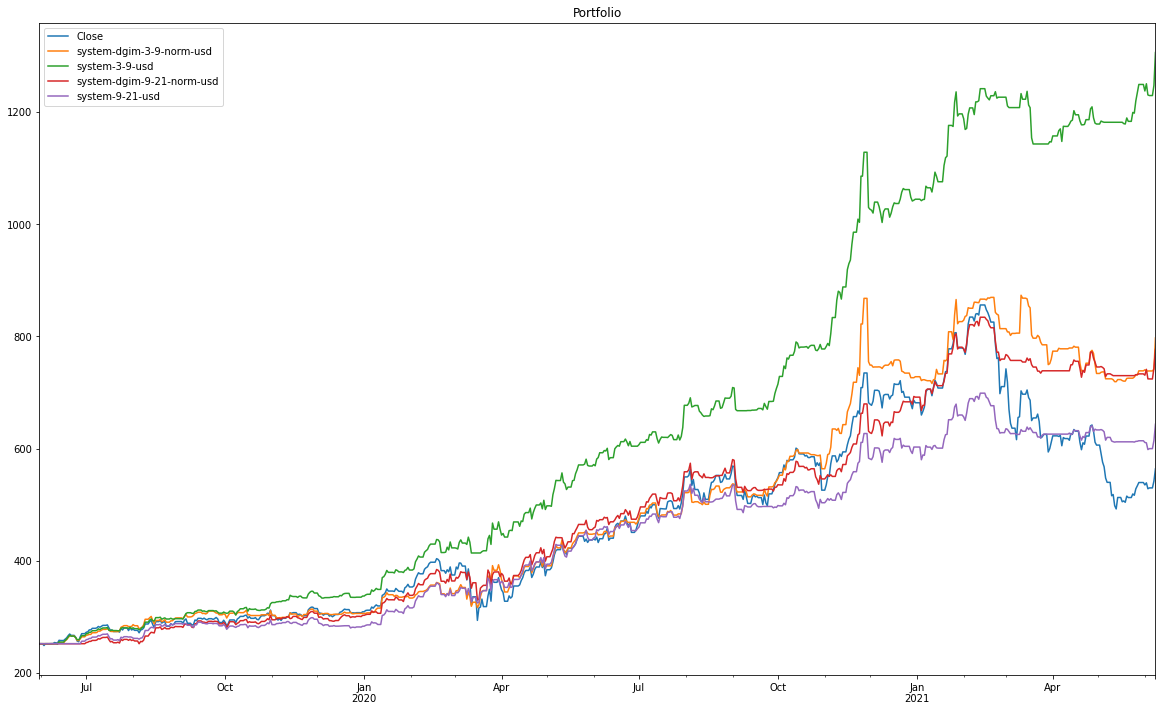

In [9]:
portfolio_usd = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio_usd += stocks[ticker].reindex(idx, fill_value=0)

portfolio_usd[['Close','system-dgim-3-9-norm-usd','system-3-9-usd','system-dgim-9-21-norm-usd','system-9-21-usd']].replace(to_replace=0, method='ffill').plot(title="Portfolio",figsize=(20,12))
portfolio_usd[['Close','system-dgim-3-9-norm-usd','system-3-9-usd','system-dgim-9-21-norm-usd','system-9-21-usd']].tail()

## Determine Mean Difference for MA and Normalized DGIM MA Performance against Baseline

In [10]:
analysis = []
for ticker in tickers:
    analysis.append({"gain-3-9": stocks[ticker]['system-3-9'].cumsum().tail(1)[0],
                     "gain-9-21": stocks[ticker]['system-9-21'].cumsum().tail(1)[0],
                     "gain-dgim-3-9-norm": stocks[ticker]['system-dgim-3-9-norm'].cumsum().tail(1)[0],
                     "gain-dgim-9-21-norm": stocks[ticker]['system-dgim-9-21-norm'].cumsum().tail(1)[0],
                     "change": stocks[ticker]['Change'].cumsum().tail(1)[0]})
analysisDf = pd.DataFrame(analysis)

meanDifference_3_9 = (analysisDf['gain-3-9'] - analysisDf['change']).mean()
meanDifference_9_21 = (analysisDf['gain-9-21'] - analysisDf['change']).mean()
meanDifference_dgim_3_9_norm = (analysisDf['gain-dgim-3-9-norm'] - analysisDf['change']).mean()
meanDifference_dgim_9_21_norm = (analysisDf['gain-dgim-9-21-norm'] - analysisDf['change']).mean()
print("meanDifference_3_9:",meanDifference_3_9)
print("meanDifference_9_21:", meanDifference_9_21)
print("meanDifference_dgim_3_9_norm:", meanDifference_dgim_3_9_norm)
print("meanDifference_dgim_9_21_norm:", meanDifference_dgim_9_21_norm)

meanDifference_3_9: 0.7068688938779957
meanDifference_9_21: -0.038745520541937126
meanDifference_dgim_3_9_norm: 0.151602121540185
meanDifference_dgim_9_21_norm: 0.13135466272510288


## Determine Winners: Most time spent as maximum USD value

In [11]:
for ticker in tickers:
    winners = []
    for i in range(len(stocks[ticker])):
        
        day_3_9 = stocks[ticker]["system-3-9-usd"][i]
        day_9_21 = stocks[ticker]["system-9-21-usd"][i]
        day_dgim_3_9_norm = stocks[ticker]["system-dgim-3-9-norm-usd"][i]
        day_dgim_9_21_norm = stocks[ticker]["system-dgim-9-21-norm-usd"][i]
    
        top = max(day_3_9,day_9_21,day_dgim_3_9_norm,day_dgim_9_21_norm)
        if top == day_3_9:
            winners.append("system-3-9-usd")
        elif top == day_9_21:
            winners.append("system-9-21-usd")
        elif top == day_dgim_3_9_norm:
            winners.append("system-dgim-3-9-norm-usd")
        elif top == day_dgim_9_21_norm:
            winners.append("system-dgim-9-21-norm-usd")
    
    day_3_9_percent = 100*winners.count("system-3-9-usd")/len(winners)
    day_9_21_percent = 100*winners.count("system-9-21-usd")/len(winners)
    day_dgim_3_9_norm_percent = 100*winners.count("system-dgim-3-9-norm-usd")/len(winners)
    day_dgim_9_21_norm_percent = 100*winners.count("system-dgim-9-21-norm-usd")/len(winners)
    print(ticker)
    print("system-3-9-usd: %0.2f%%, system-9-21-usd: %0.2f%%, system-dgim-3-9-norm-usd: %0.2f%%, system-dgim-9-21-norm-usd: %0.2f%%" % (day_3_9_percent, day_9_21_percent, day_dgim_3_9_norm_percent, day_dgim_9_21_norm_percent))
    print("Winner: %s" % max(winners,key=winners.count))
    print()

APPN
system-3-9-usd: 11.37%, system-9-21-usd: 0.00%, system-dgim-3-9-norm-usd: 88.63%, system-dgim-9-21-norm-usd: 0.00%
Winner: system-dgim-3-9-norm-usd

TDOC
system-3-9-usd: 43.73%, system-9-21-usd: 2.75%, system-dgim-3-9-norm-usd: 16.08%, system-dgim-9-21-norm-usd: 37.45%
Winner: system-3-9-usd

WD
system-3-9-usd: 76.86%, system-9-21-usd: 19.61%, system-dgim-3-9-norm-usd: 2.94%, system-dgim-9-21-norm-usd: 0.59%
Winner: system-3-9-usd

BOMN
system-3-9-usd: 81.96%, system-9-21-usd: 2.75%, system-dgim-3-9-norm-usd: 13.73%, system-dgim-9-21-norm-usd: 1.57%
Winner: system-3-9-usd

KNSL
system-3-9-usd: 99.80%, system-9-21-usd: 0.20%, system-dgim-3-9-norm-usd: 0.00%, system-dgim-9-21-norm-usd: 0.00%
Winner: system-3-9-usd

